In [ ]:
PATH = "dataset/"
data_filename = "filtered_data.csv"


import pandas as pd

df = pd.read_csv(f"{PATH}/{data_filename}")
df.fillna(0, inplace=True)

df['Data e Hora'] = pd.to_datetime(df['Data e Hora'])
df = df.set_index('Data e Hora')
df.head()

,producao_total,producao_renovavel,hidrica,eolica,solar,ondas,biomassa,producao_nao_renovavel,carvao,gas_natural,termica,producao_por_bombagem,importacao,exportacao
Data e Hora,,,,,,,,,,,,,,
2011-01-01,107.975628,73.076341,63.952042,2.142578,0.122491,0.0,6.859230,34.484478,4.3443,28.367837,1.772341,0.414810,12.4186,0.0852
2011-01-02,109.657562,71.219553,62.732572,1.469945,0.197608,0.0,6.819428,37.876984,0.7383,35.343969,1.794715,0.561025,20.8615,0.0000
2011-01-03,150.642916,74.660080,63.158904,4.503582,0.166772,0.0,6.830821,74.808327,14.9438,55.179956,4.684572,1.174509,13.4903,1.0916
2011-01-04,159.833303,101.106584,64.904843,28.734425,0.256511,0.0,7.210805,58.567678,4.8496,48.985982,4.732096,0.159041,9.3552,0.7629
2011-01-05,170.854279,133.687873,67.566754,58.869586,0.208719,0.0,7.042814,36.428947,4.6337,27.003927,4.791320,0.737460,6.7881,6.8363


In [ ]:
import numpy as np

# df = df.apply(np.log1p)
# df = df.apply(lambda col: col.diff(), axis=0).iloc[2:]
# df.fillna(0, inplace=True)
df.head()

,producao_total,producao_renovavel,hidrica,eolica,solar,ondas,biomassa,producao_nao_renovavel,carvao,gas_natural,termica,producao_por_bombagem,importacao,exportacao
Data e Hora,,,,,,,,,,,,,,
2011-01-01,107.975628,73.076341,63.952042,2.142578,0.122491,0.0,6.859230,34.484478,4.3443,28.367837,1.772341,0.414810,12.4186,0.0852
2011-01-02,109.657562,71.219553,62.732572,1.469945,0.197608,0.0,6.819428,37.876984,0.7383,35.343969,1.794715,0.561025,20.8615,0.0000
2011-01-03,150.642916,74.660080,63.158904,4.503582,0.166772,0.0,6.830821,74.808327,14.9438,55.179956,4.684572,1.174509,13.4903,1.0916
2011-01-04,159.833303,101.106584,64.904843,28.734425,0.256511,0.0,7.210805,58.567678,4.8496,48.985982,4.732096,0.159041,9.3552,0.7629
2011-01-05,170.854279,133.687873,67.566754,58.869586,0.208719,0.0,7.042814,36.428947,4.6337,27.003927,4.791320,0.737460,6.7881,6.8363


In [565]:
serie = ['producao_nao_renovavel']
df = df[serie]

train_ratio = 0.8
val_ratio = 0.3
test_ratio = 0.2

train_split = int(df.shape[0] * train_ratio * (1 - val_ratio))
val_split = int(df.shape[0] * train_ratio * val_ratio)
test_split = int(df.shape[0] * test_ratio)

df_train = df[:train_split]
df_val = df[train_split:train_split + val_split]
df_test = df[:test_split]

In [566]:
def create_sequences(data, timesteps):
    X, y = [], []
    num_samples = len(data) // timesteps  # Ensure only full sequences are used

    for i in range(num_samples):
        start = len(data) - (i + 1) * timesteps
        end = start + timesteps

        if start >= 0:  # Ensure valid indexing
            X.append(data[start:end])
            y.append(data[start - 1])

    return np.array(X), np.array(y)

In [ ]:
import tensorflow as tf
import keras
from sklearn.preprocessing import StandardScaler, PowerTransformer
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import optimizers


SEQ_LENGTH = 1 # do not change this parameter
LEARNING_RATE = 1e-4

# Define the checkpoint callback
checkpoint = ModelCheckpoint(f"{PATH}/best_non_renewables_model.weights.h5", monitor='val_loss', save_best_only=True, save_weights_only=True, mode='min')

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


# Normalize the data
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaler = StandardScaler()
scaler = PowerTransformer()

df_train_scaled = scaler.fit_transform(df_train)
df_val_scaled = scaler.transform(df_val)
df_test_scaled = scaler.transform(df_test)


X_train, y_train = create_sequences(df_train_scaled, SEQ_LENGTH)
X_val, y_val = create_sequences(df_val_scaled, SEQ_LENGTH)
X_test, y_test = create_sequences(df_test_scaled, 1) # to forecast a single day


print("Training set size:", X_train.shape)
print("Validation set size:", X_val.shape)
print("Test set size:", X_test.shape)

# USE LSTM-MDN

# Define the LSTM model
model = keras.Sequential([
    keras.layers.LSTM(256, return_sequences=True, input_shape=(SEQ_LENGTH, df_train_scaled.shape[1]), activation='tanh'),
    keras.layers.Dropout(0.15),
    keras.layers.LSTM(128, return_sequences=True, activation='tanh'),
    keras.layers.Dropout(0.1),
    keras.layers.LSTM(64, activation='tanh'),

    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE), loss='log_cosh', metrics=['mse', 'mae'])

# Train the model
model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_val, y_val), callbacks=[checkpoint, early_stopping])

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

Training set size: (2903, 1, 1)
Validation set size: (1244, 1, 1)
Test set size: (1036, 1, 1)


/Users/xoutoz/workspace/master/ASTP/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.3726 - mae: 0.8018 - mse: 0.9720 - val_loss: 0.5164 - val_mae: 0.9802 - val_mse: 1.4208
Epoch 2/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.3200 - mae: 0.7261 - mse: 0.8121 - val_loss: 0.2541 - val_mae: 0.6218 - val_mse: 0.6377
Epoch 3/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.1624 - mae: 0.4699 - mse: 0.3881 - val_loss: 0.2456 - val_mae: 0.5975 - val_mse: 0.6268
Epoch 4/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.1637 - mae: 0.4676 - mse: 0.3897 - val_loss: 0.2501 - val_mae: 0.6075 - val_mse: 0.6369
Epoch 5/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.1549 - mae: 0.4516 - mse: 0.3670 - val_loss: 0.2496 - val_mae: 0.6093 - val_mse: 0.6326
Epoch 6/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.1541 - mae: 0.4586 - mse: 0.3618 - val_loss: 0.2467 - val_mae: 0.6005 - val_mse: 0.6288
Epoch 7/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.1628 - mae: 0.4652 - mse: 0.3899 - val

In [568]:
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred.shape

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


(1036, 1)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/Users/xoutoz/workspace/master/ASTP/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/Users/xoutoz/workspace/master/ASTP/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


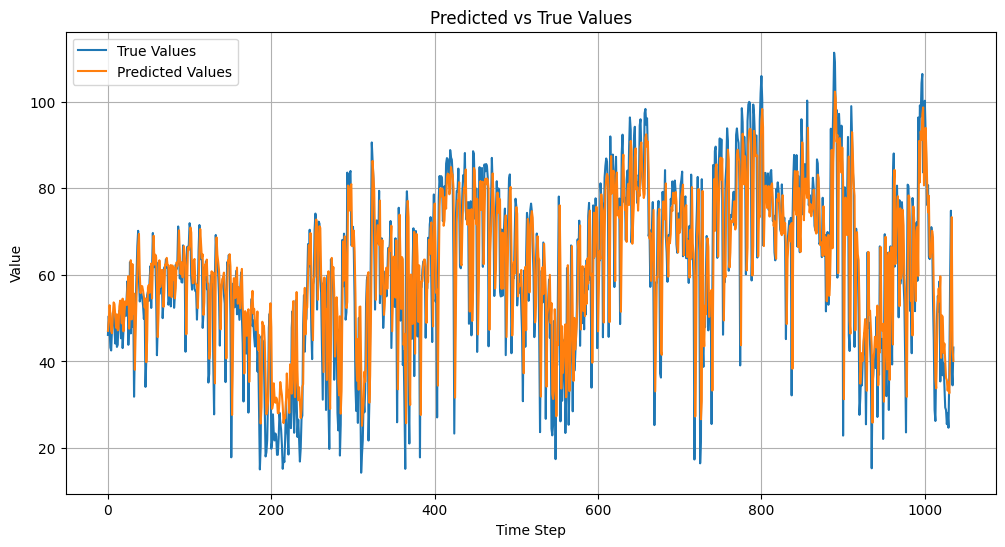

Mean Absolute Percentage Error (MAPE): 21.267%
R-squared (R2): 0.5410951179354129


In [569]:
# Make predictions on the test set
y_pred = model.predict(X_test)



y_pred_reshaped = y_pred.flatten().reshape(-1, 1)
y_test_reshaped = y_test.flatten().reshape(-1, 1)

# Inverse transform the predictions and actual values to the original scale
y_pred_original = scaler.inverse_transform(y_pred_reshaped)
y_test_original = scaler.inverse_transform(y_test_reshaped)

# Create a DataFrame for easier plotting and comparison
comparison_df = pd.DataFrame({ 'Predicted': y_pred_original.flatten(), 'True': y_test_original.flatten() })

# Plotting the predicted vs true values
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(comparison_df['True'], label='True Values')
plt.plot(comparison_df['Predicted'], label='Predicted Values')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Predicted vs True Values')
plt.legend()
plt.grid(True)
plt.show()

# Calculate additional metrics (optional)
from sklearn.metrics import r2_score
mape = np.mean(np.abs((y_test_original - y_pred_original) / y_test_original)) * 100
r2 = r2_score(y_test_original, y_pred_original)

print(f"Mean Absolute Percentage Error (MAPE): {mape:.3f}%")
print(f"R-squared (R2): {r2}")
